(506, 13) (506,)


Text(0, 0.5, 'Predicted target')

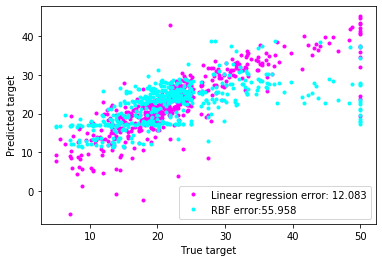

In [1]:
# Appendix A: Regression with Linear and Radial Basis Function Models
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
raw = load_boston()

# Last column is target
X = raw.data
y = raw.target
N = X.shape[0]
print(X.shape, y.shape)
# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T @ X)) @ X.T @ y
yh_lin = X @ w

# J = 20basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data
def gaussian(x, u, sigma):
    return(np.exp(-0.5 * np.linalg.norm(x-u) / sigma))

from sklearn.cluster import KMeans
J = 20
kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
sig = np.std(X)
# Construct design matrix
U = np.zeros((N,J))
for i in range(N):
    for j in range(J):
#        U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j]) 
        U[i][j] = gaussian(X[i], kmeans.cluster_centers_[j], sig)
# Solve RBF model, predict and plot
w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) @ y
yh_rbf = np.dot(U,w)
plt.plot(y, yh_lin, '.', Color='magenta', label='Linear regression error: %.3f' % (np.square(y-yh_lin).mean() / 2))
plt.plot(y, yh_rbf, '.', Color='cyan', label= 'RBF error:%.3f' % np.square(y-yh_rbf).mean())
plt.legend()
plt.xlabel('True target')
plt.ylabel('Predicted target')
# plt.savefig('boston_data')

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
import sys
import sklearn.preprocessing
import pickle
np.random.seed(0)

def timeit(func):
    '''
    A decorator which computes the time cost.
    '''
    def wrapper(*args, **kw):
        start = time.time()
        print('%s starts...' % (func.__name__))
        res = func(*args, **kw)
        print('%s completed: %.3f s' % (func.__name__, time.time() - start))
        return res
    return wrapper

class MountainCar:

    def __init__(self, env):
        self.env = env
        self.n_states = 40
        self.episodes = 400
        self.initial_lr = 1.0
        self.min_lr = 0.005
        self.gamma = 0.99
        self.max_stps = 300
        self.max_iter = 8000
        self.epsilon = 0.05
        self.env = env.unwrapped
        self.env.seed(0)
        self._scaler()
        print('max_iter: %s, episodes: %s' %(self.max_iter, self.episodes))
    
    # Quantize the states
    def _scaler(self):
        env_low = self.env.observation_space.low
        env_high = self.env.observation_space.high
        env_den = (env_high - env_low) / self.n_states
        self.pos_den = env_den[0]
        self.vel_den = env_den[1]
        self.pos_high = env_high[0]
        self.pos_low = env_low[0]
        self.vel_high = env_high[1]
        self.vel_low = env_low[1]

    def discretization(self, obs):
        pos_scaled = int((obs[0] - self.pos_low) / self.pos_den)
        vel_scaled = int((obs[1] - self.vel_low) / self.vel_den)
        return pos_scaled, vel_scaled

    def train(self, epsilon=0.05):
        print('epsilon', epsilon)
        q_table = np.zeros((self.n_states, self.n_states, self.env.action_space.n))
        total_steps = 0
        for episode in range(self.episodes):
            # print("Episode:", episode)
            obs = self.env.reset()
            total_reward = 0
            alpha = max(self.min_lr,self.initial_lr*(self.gamma**(episode//100)))
            steps = 0
            for i in range(self.max_iter):
                pos, vel = self.discretization(obs)
                if np.random.uniform(low=0, high=1) < epsilon:
                    a = np.random.choice(self.env.action_space.n)
                else:
                    a = np.argmax(q_table[pos][vel])
                obs, reward, terminate,_ = self.env.step(a)
                total_reward += abs(obs[0]+0.5)
                pos_, vel_ = self.discretization(obs)
                # Q function update
                q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+self.gamma*np.max(q_table[pos_][vel_]))
                steps += 1
                if terminate:
                    break
            if episode % 50 == 0:
                print('Episode: %s, Total reward: %s' % (episode, total_reward))

        output = open('./q_table.pkl', 'wb')
        pickle.dump(q_table, output)
        output.close()

    def test(self, policy):
        #policy q table
        print('testing...')
        steps = 0
        obs = self.env.reset()
        while True:
            self.env.render()
            pos, vel = self.discretization(obs)
            a = policy[pos][vel]
            obs, reward, terminate, _ = self.env.step(a)
            steps += 1
            if terminate:
                print('total steps:', steps)
                break

class RBFApproximation(MountainCar):
    
    def __init__(self, env):
        super().__init__(env)
        pkl_file = open('./q_table.pkl', 'rb')
        self.q_table = pickle.load(pkl_file)
        pkl_file.close()

    def construct_dataset(self):
        """
        flatten the 3-d q_table into 2-d features, 1-d actions and y
        Output: features, y, actions
        """
        data = np.zeros([self.n_states * self.n_states * 3, 4])
        c = 0  # count of features
        for i in range(self.q_table.shape[0]):
            for j in range(self.q_table.shape[1]):
                for k in range(self.env.action_space.n):
                    data[c][0] = i
                    data[c][1] = j
                    data[c][2] = k
                    data[c][3] = self.q_table[i][j][k]
                    c += 1
        assert c == self.n_states * self.n_states * 3
        y = np.expand_dims(data[:, 3], axis=1)
        features = data[:, 0:2]
        actions = data[:, 2]
#         print('feature shape:', features.shape)
#         print('y shape:', y.shape)
        return features, y, actions    

    def construct_policy(self, y):
        """
        Input: q_table
        Output: optimal actions
        """
        q_table_n = np.zeros([40,40,3])
        count = 0
        for i in range(40):
            for j in range(40):
                for k in range(3):
                    q_table_n[i][j][k] = y[count]
                    count += 1
        policy = np.argmax(q_table_n, axis=2)
        return policy, q_table_n
    
    def design_matrix(self, X, J):
        """
        Input: 
        X: data
        J: number of radial basis
        Output: 
        U radial basis matirx
        """
        Kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
        sig = np.std(X)
        N = X.shape[0]
        U = np.zeros([N, J])
        for i in range(N):
            for j in range(J):
                u = np.linalg.norm(X[i] - Kmeans.cluster_centers_[j])
                U[i][j] = np.exp(- np.square(u / sig))
        return U

    def gradient(self, w, X, y):
        """
        Input: 
        w: parameter
        X: data
        y:label
        Output: 
        gradients
        """
        return (- 1 / len(X)) * X.T.dot(y - X.dot(w))

    def cost_func(self, w, X, y):
        """
        Input: 
        w: parameter
        X: data
        y:label
        Output: 
        mean square error of predicted label and true label
        """
        y_pred = X.dot(w)
        return np.square(y - y_pred).mean() / 2

    def train_tabular(self, U, J, actions, y):
        """
        Input: u [4800, 20]
        J, number of radial basis 
        actions[4800,]
        y[4800, 1]
        MaxIter:number of sgd
        Output: w after gradient update
        """
        alpha = 0.001
        w = np.random.rand(J, 3)
        for _ in range(10):
            for i, u in enumerate(U):
                u = np.expand_dims(u, axis=0)
                a = int(actions[i])
                gd = self.gradient(w[:, a], u, y[i])
                w[:, a] = w[:, a] - alpha * gd
        return w

    def approximate(self, J):
        """
        training and test the policy got by RBF approximator
        """
        mse_his = []
        self.train(epsilon=0.05)
        print('construct dataset from the learned q_table...')
        features, y, actions = self.construct_dataset()
        U = self.design_matrix(features, J)
        w = self.train_tabular(U, J, actions, y)
        y_pred = np.zeros(y.shape)
        for i, u in enumerate(U):
            y_pred[i] = u.dot(w[:, int(actions[i])])

        mse_loss = np.square(y - y_pred).mean() / 2
        print('mse loss: %s with J: %s' % (mse_loss, J) )

        #test
        new_policy, q_table_RBF = self.construct_policy(y_pred)
        output_RBF = open('./q_table_RBF.pkl', 'wb')
        pickle.dump(q_table_RBF, output_RBF)
        output_RBF.close()
        self.test(new_policy)
        
class QLearningAndSarsa(MountainCar):
    def __init__(self, env, J=20, epsilon=0.05):
        super().__init__(env)
        self.J = J
        self.epsilon = epsilon
        observation_examples = np.array(
            [self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler().fit(observation_examples)
        observation_examples = self.scaler.transform(observation_examples)
        kmeans = KMeans(n_clusters=self.J, random_state=0).fit(observation_examples)
        self.sig = np.std(observation_examples)
        self.clusters_centers = kmeans.cluster_centers_
        print(self.clusters_centers.shape)
        del observation_examples

    @timeit
    def QLearning(self):
        w = np.zeros([self.J, self.env.action_space.n])
        episodes = 400
        steps = []
        print('Number of episodes:', episodes)
        for episode in range(episodes):
            step = 0
            obs = self.env.reset()
            state = self.featuriser(obs)
            alpha = 0.02
            while True:
                step += 1
                action = self.greedy_policy(w, state, self.epsilon)
                obs, reward, terminate,_ = self.env.step(action)
                #state
                next_state = self.featuriser(obs)
                next_Q_values = self.Q_value(w, next_state)
                target = reward + self.gamma * np.max(next_Q_values)
                # print(w.shape, state.shape, target.shape)
                gd = self.gradient(w[:, int(action)], state, target)
                w[:, int(action)] -= alpha * gd
                state = next_state
                if terminate:
                    break
            steps.append(step)
            if episode % 20 == 0:
                print('Episode: %s, Total step: %s' % (episode, step))
        self.w = w
        plt.xlabel('number of episodes')
        plt.ylabel('number of steps')
        plt.plot(steps, label='Average step=%s' % np.mean(steps))
        plt.legend()
        plt.title('RBF with QLearning method completed in 19.148s')
        plt.savefig('QLearning')
    def greedy_policy(self, w, state, epsilon):
        if np.random.uniform(low=0, high=1) < epsilon:
            return np.random.choice(self.env.action_space.n)
        else:
            return np.argmax([self.Q_value(w, state, action) for action in range(self.env.action_space.n)])

    def Q_value(self, w, state, action=None):
        if action == None:
            return state.dot(w)
        else:
            return state.dot(w[:, int(action)])

    def featuriser(self, observation):
        pos_scaled, vel_scaled = self.scaler.transform([observation])[0]
        x = np.array([pos_scaled, vel_scaled])
        u = np.zeros([1, self.J])
        for i in range(self.J):
            temp = np.linalg.norm(x - self.clusters_centers[i])
            u[0][i] = np.exp(-np.square(temp / self.sig))
        return u

    def gradient(self, w, X, y):
        return (- 1 / len(X)) * (X.T.dot(y - X.dot(w)))

    def learned_policy(self, w, state):
        return np.argmax([self.Q_value(w, state, action) for action in range(self.env.action_space.n)])
    @timeit
    def Sarsa(self):
        w = np.zeros([self.J, self.env.action_space.n])
        episodes = 400
        steps = []
        print('Number of episodes:', episodes)
        for episode in range(episodes):
            step = 0
            obs = self.env.reset()
            state = self.featuriser(obs)
            action = self.greedy_policy(w, state, self.epsilon)
            alpha = 0.01
            while True:
                step += 1
                obs, reward, terminate,_ = self.env.step(action)
                next_state = self.featuriser(obs)
                next_action = self.greedy_policy(w, next_state, self.epsilon)
                next_Q_values = self.Q_value(w, next_state, int(next_action))
                target = (reward + self.gamma * next_Q_values)
                gd = self.gradient(w[:, int(action)], state, target)
                w[:, int(action)] -= alpha * gd
                state = next_state
                action = next_action
                if terminate:
                    # target = reward
                    # dw = self.gradient(w[:, int(action)], state, target)
                    # w[:, int(action)] -= alpha * dw
                    break
            steps.append(step)
            if episode % 20 == 0:
                print('Episode: %s, Total step: %s' % (episode, step))
        self.w = w
        plt.xlabel('number of episodes')
        plt.ylabel('number of steps')
        plt.plot(steps, label='Average step=%s' % np.mean(steps))
        plt.legend()
        plt.title('RBF with SARSA method completed in 18.141s')
        plt.savefig('SARSA')
    def test(self):
        print('testing...')
        steps = 0
        obs = self.env.reset()
        while True:
            self.env.render()
            state = self.featuriser(obs)
            action = self.learned_policy(self.w, state)
            obs, reward, terminate, _ = self.env.step(action)
            steps += 1
            if terminate:
                print('total steps:', steps)
                break

def test_model_one(J):
    env = gym.make('MountainCar-v0')
    model = RBFApproximation(env)
    model.approximate(J)
    env.close()


def test_model_Sarsa():
    env = gym.make('MountainCar-v0')
    model = QLearningAndSarsa(env)
    # model.QLearning()
    model.Sarsa()
    model.test()
    env.close()
    
def test_original():
    env = gym.make('MountainCar-v0')
    model = MountainCar(env)
    model.train()
    pkl_file = open('./q_table.pkl', 'rb')
    q_table = pickle.load(pkl_file)
    pkl_file.close()
    policy = np.argmax(q_table, axis=2)
    model.test(policy)
    
def test_model_Q():
    env = gym.make('MountainCar-v0')
    model = QLearningAndSarsa(env)
    model.QLearning()
    model.test()
    env.close()


In [8]:
J = 20
test_model_one(J)

max_iter: 8000, episodes: 400
epsilon 0.05
Episode: 0, Total reward: 2215.2421431824955
Episode: 50, Total reward: 194.5873609724867
Episode: 100, Total reward: 136.54469780749903
Episode: 150, Total reward: 127.70898360167823
Episode: 200, Total reward: 161.28040493293972
Episode: 250, Total reward: 78.4178242372415
Episode: 300, Total reward: 410.4478682724766
Episode: 350, Total reward: 113.96673707931971
construct dataset from the learned q_table...
mse loss: 51.365916797017796 with J: 20
testing...
total steps: 84


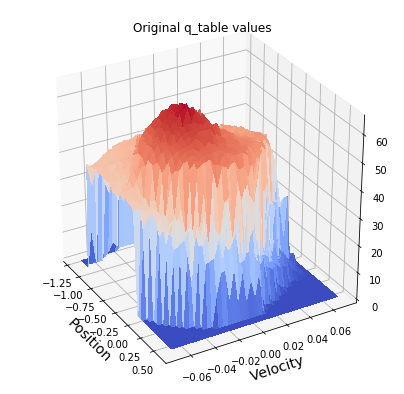

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pickle

#original q table
pkl_file = open('./q_table.pkl', 'rb')
q_table = pickle.load(pkl_file)
pkl_file.close()

pos_3d = np.linspace(-1.2, 0.6, 40)
vel_3d = np.linspace(-0.07, 0.07, 40)
pos_grid, vel_grid = np.meshgrid(pos_3d, vel_3d)
q_table_z = np.max(q_table,2)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(pos_grid, vel_grid, -q_table_z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('Original q_table values')
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.view_init(30,-30)
plt.savefig('q_table')

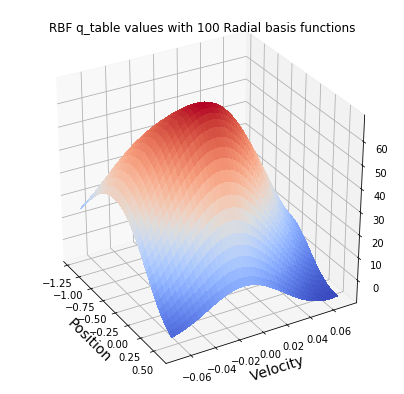

In [17]:
#RBF q table
pkl_file = open('./q_table_RBF.pkl', 'rb')
q_table = pickle.load(pkl_file)
pkl_file.close()


pos_3d = np.linspace(-1.2, 0.6, 40)
vel_3d = np.linspace(-0.07, 0.07, 40)
pos_grid, vel_grid = np.meshgrid(pos_3d, vel_3d)
q_table = np.max(q_table, 2)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(pos_grid, vel_grid, -q_table, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('RBF q_table values with %s Radial basis functions' % J)
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.view_init(30,-30)
# plt.savefig('RBF %s' % J)

max_iter: 8000, episodes: 400
(20, 2)
Sarsa starts...
Number of episodes: 400
Episode: 0, Total step: 5652
Episode: 20, Total step: 158
Episode: 40, Total step: 150
Episode: 60, Total step: 98
Episode: 80, Total step: 114
Episode: 100, Total step: 117
Episode: 120, Total step: 120
Episode: 140, Total step: 149
Episode: 160, Total step: 110
Episode: 180, Total step: 115
Episode: 200, Total step: 119
Episode: 220, Total step: 108
Episode: 240, Total step: 91
Episode: 260, Total step: 108
Episode: 280, Total step: 112
Episode: 300, Total step: 98
Episode: 320, Total step: 113
Episode: 340, Total step: 94
Episode: 360, Total step: 87
Episode: 380, Total step: 115
Sarsa completed: 18.174 s
testing...
total steps: 85


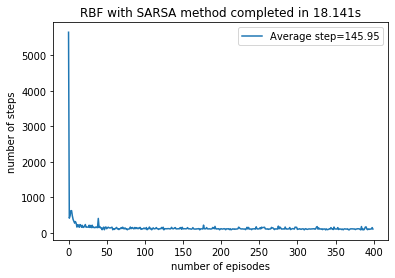

In [6]:
test_model_Sarsa()

max_iter: 8000, episodes: 400
(20, 2)
QLearning starts...
Number of episodes: 400
Episode: 0, Total step: 2390
Episode: 20, Total step: 151
Episode: 40, Total step: 139
Episode: 60, Total step: 98
Episode: 80, Total step: 110
Episode: 100, Total step: 110
Episode: 120, Total step: 109
Episode: 140, Total step: 149
Episode: 160, Total step: 109
Episode: 180, Total step: 143
Episode: 200, Total step: 108
Episode: 220, Total step: 109
Episode: 240, Total step: 152
Episode: 260, Total step: 131
Episode: 280, Total step: 106
Episode: 300, Total step: 101
Episode: 320, Total step: 107
Episode: 340, Total step: 84
Episode: 360, Total step: 89
Episode: 380, Total step: 133
QLearning completed: 18.253 s
testing...
total steps: 86


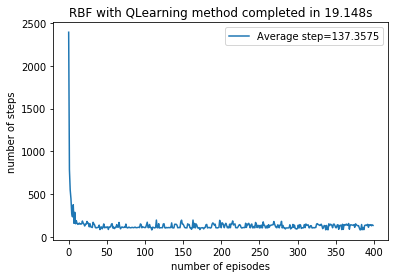

In [40]:
test_model_Q()